In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

from statsmodels.tsa.stattools import adfuller

In [3]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

# Wczytanie danych
(interwał dzienny)


In [44]:
gaz = pd.read_csv(os.path.join("Futures", "Daily_Natural_Gas_Futures_Contract_1.csv"), skiprows=5, parse_dates=['Data'], names=["Data", "Cena gazu [USD/Million Btu]"])

In [45]:
ropa_csv = pd.read_csv(os.path.join("Futures", "Brent_Crude_Oil_Last_Day_BZ=F.csv"))
ropa = pd.DataFrame()

In [46]:
ropa["Data"] = ropa_csv["Date"]
ropa["Cena ropy [USD/Barrel]"] = ropa_csv["Close*"]

In [47]:
ropa.dtypes

Data                       object
Cena ropy [USD/Barrel]    float64
dtype: object

In [48]:
ropa = ropa.astype({"Data": "datetime64[ns]"})

In [49]:
gaz.dtypes

Data                           datetime64[ns]
Cena gazu [USD/Million Btu]           float64
dtype: object

In [50]:
df = gaz.merge(ropa, on="Data", how="inner").dropna() # zbiorcza tabela połączona po danych - do analizy dwuwymiarowej

In [51]:
df.head()

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel]
0,2023-04-11,2.1860,85.6100
1,2023-04-10,2.1720,84.1800
2,2023-04-05,2.1550,84.9900
3,2023-04-04,2.1060,84.9400
4,2023-04-03,2.0970,84.9300


In [52]:
y_gaz = df['Cena gazu [USD/Million Btu]']
y_ropa = df['Cena ropy [USD/Barrel]']

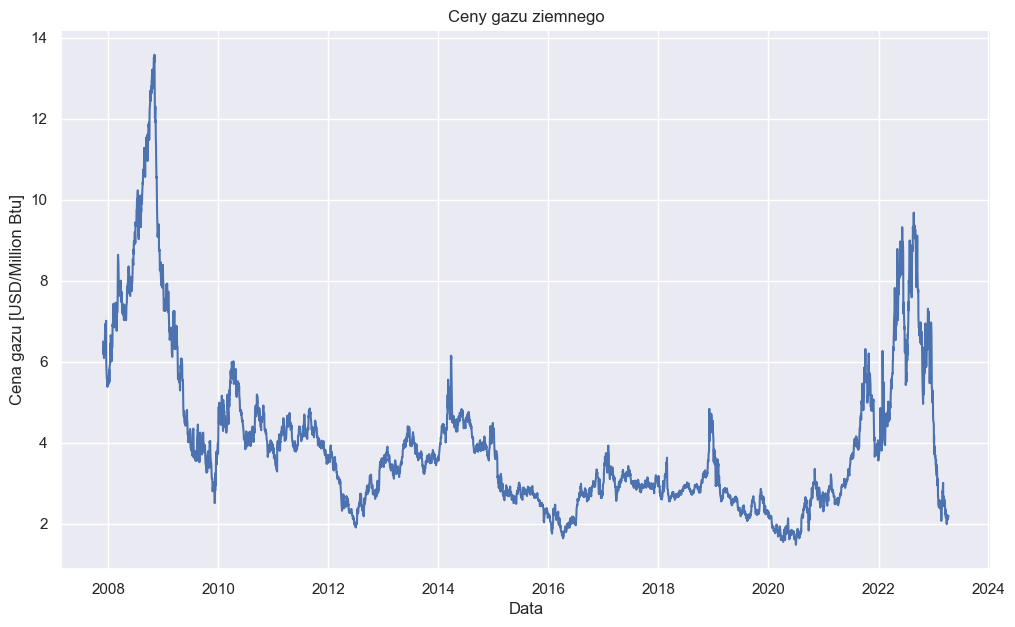

In [53]:
sns.lineplot(x=gaz.Data, y=y_gaz)
plt.title('Ceny gazu ziemnego')
plt.xlabel('Data')
# plt.savefig('ceny_gazu.png')
plt.show()

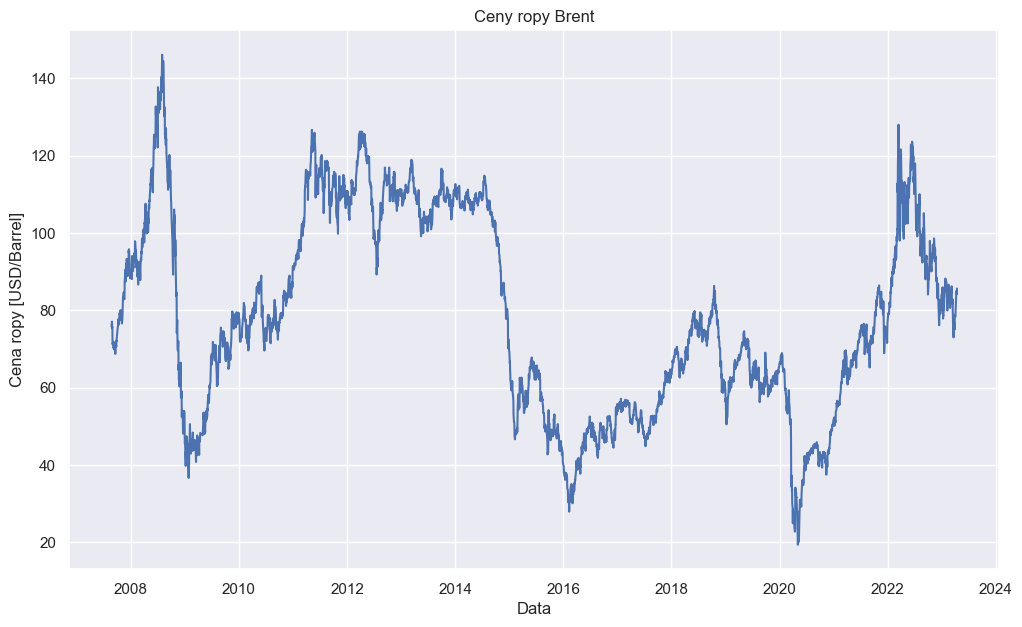

In [54]:
sns.lineplot(x=ropa.Data, y=y_ropa)
plt.title('Ceny ropy Brent')
plt.xlabel('Data')
# plt.savefig('ceny_ropy.png')
plt.show()

### Przygotowanie danych

Zwroty logarytmiczne
$$ y_t = \ln(\frac{x_t}{x_{t-1}})$$

In [ ]:
df['przyrosty_log_gaz'] = np.log(y_gaz).diff().dropna()
df['przyrosty_log_ropa'] = np.log(y_ropa).diff().dropna()

In [58]:
df.shape

(3873, 5)

In [59]:
df.dropna()

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel],przyrosty_log_gaz,przyrosty_log_ropa
1,2023-04-10,2.1720,84.1800,-0.0064,-0.0168
2,2023-04-05,2.1550,84.9900,-0.0079,0.0096
3,2023-04-04,2.1060,84.9400,-0.0230,-0.0006
4,2023-04-03,2.0970,84.9300,-0.0043,-0.0001
5,2023-03-31,2.2160,79.7700,0.0552,-0.0627
...,...,...,...,...,...
3868,2007-08-03,6.0900,74.7500,-0.0192,0.0491
3869,2007-08-02,6.1060,75.7600,0.0026,0.0134
3870,2007-08-01,6.3520,75.3500,0.0395,-0.0054
3871,2007-07-31,6.1910,77.0500,-0.0257,0.0223


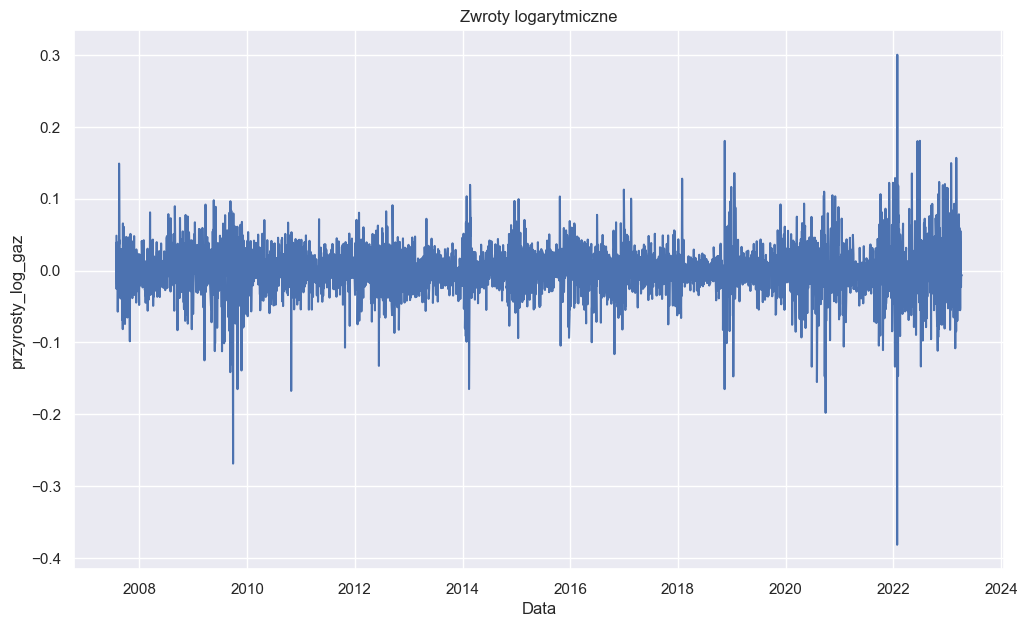

In [60]:
sns.lineplot(x=df.Data, y=df.przyrosty_log_gaz)
plt.title('Zwroty logarytmiczne')
plt.xlabel('Data')
# plt.savefig('log_przyrosty_gazu.png')
plt.show()

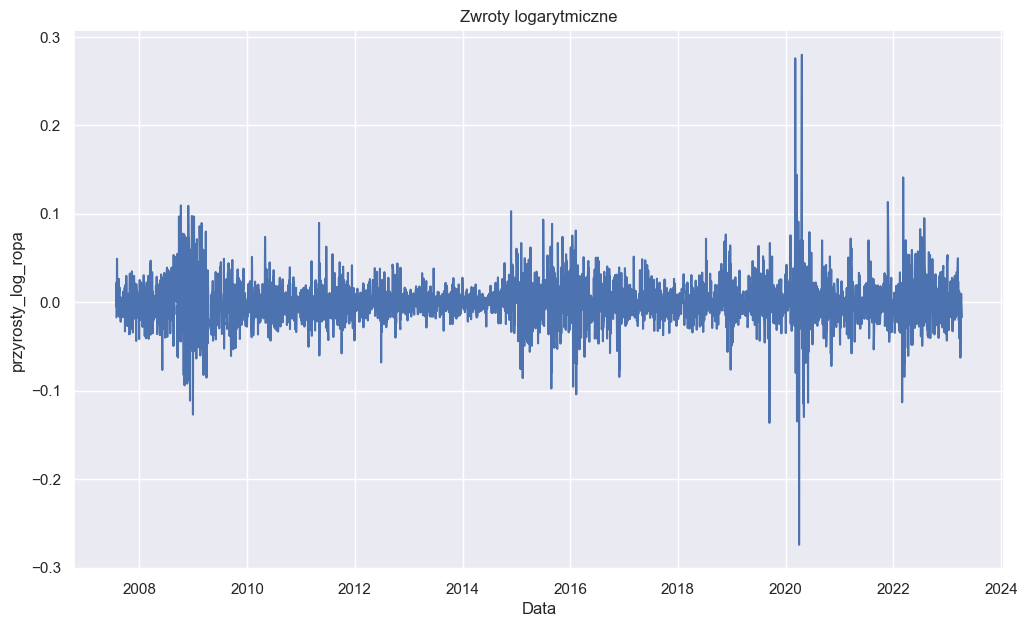

In [61]:
sns.lineplot(x=df.Data, y=df.przyrosty_log_ropa)
plt.title('Zwroty logarytmiczne')
plt.xlabel('Data')
# plt.savefig('log_przyrosty_ropy.png')
plt.show()

### Stacjonarność przyrostów logarytmicznych

In [62]:
def adf_test(x):
    p_val = []
    trend = ['Stała', 'Linia', 'Parabola', 'Brak']
    trends = ['c', 'ct', 'ctt', 'nc']
    for i in trends:
        p_val.append(adfuller(x, regression=i)[1])
    return pd.DataFrame({'Trend': trend, 'P-value':p_val})

In [63]:
adf_test(df.przyrosty_log_gaz.dropna())

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


,Trend,P-value
0,Stała,0.0000
1,Linia,0.0000
2,Parabola,0.0000
3,Brak,0.0000


In [64]:
adf_test(df.przyrosty_log_ropa.dropna())

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


,Trend,P-value
0,Stała,0.0000
1,Linia,0.0000
2,Parabola,0.0000
3,Brak,0.0000


p-wartość < 0.05 - przyrosty są stacjonarne
# Analiza jednowymiarowa
## Gaz ziemny

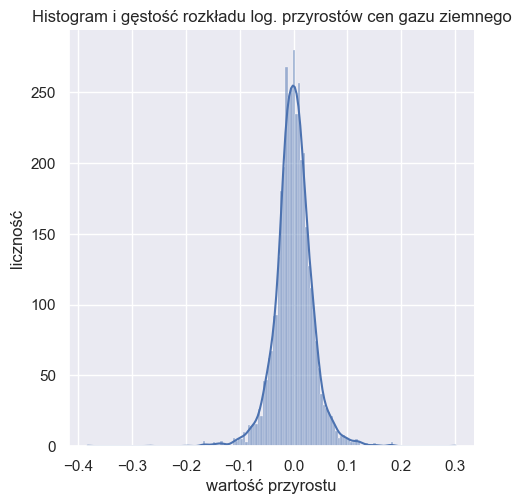

In [66]:
sns.displot(x=df.przyrosty_log_gaz, kde=True)
plt.title('Histogram i gęstość rozkładu log. przyrostów cen gazu ziemnego')
plt.xlabel('wartość przyrostu')
plt.ylabel('liczność')
# plt.savefig('histogram_gaz.png')
plt.show()

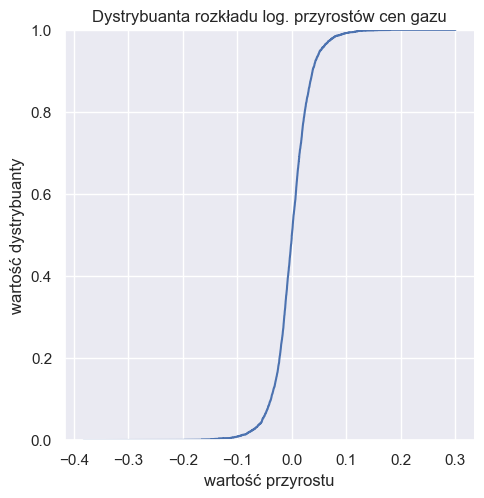

In [67]:
sns.displot(x=df.przyrosty_log_gaz, kind='ecdf')
plt.title('Dystrybuanta rozkładu log. przyrostów cen gazu')
plt.xlabel('wartość przyrostu')
plt.ylabel('wartość dystrybuanty')
# plt.savefig('dystr_gaz.png')
plt.show()